In [1]:
!pip install "dask[complete]"

In [2]:
!pip install nltk

In [3]:
!pip install wordcloud

In [4]:
!pip install gensim

In [5]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [6]:
!pip install 'transformers[torch]'

## Import Libraries


To start, we have imported all the necessary libraries. Some of them were installed previously using the "pip install" command. These libraries play a vital role in our web scraping process to obtain a text corpus, and we'd like to provide more details on how we are using Dask and Beautiful Soup in parallel to achieve this:

Dask is a pivotal library that enables us to efficiently scale computations from a single machine to work in parallel. It allows us to distribute the scraping tasks across multiple workers, effectively speeding up the process.

From the "bs4" package, we import Beautiful Soup, which is a versatile tool used for parsing and navigating HTML. Beautiful Soup helps us extract structured information from the web pages we are scraping.

In addition to Dask and Beautiful Soup, we are also leveraging the following libraries:

requests: It allows us to fetch web pages' content efficiently. We use it to access and retrieve the HTML data from the target website, making it available for parsing.


In [7]:
from dask.distributed import Client, LocalCluster, progress,  as_completed
from dask import bag as db
import dask
from tqdm import tqdm
import os
from dask.diagnostics import ProgressBar
from time import time

In [8]:
!rm -r ./output_mañaneras

In [9]:
!curl ipecho.net/plain
!sudo lsof -i -P -n | grep LISTEN

152.70.138.140sudo: lsof: command not found


In [10]:
from bs4 import BeautifulSoup
import requests
import re
import random
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Function to Scrape Lopez Obrador's website

The function "download_AMLOVE_conferences" takes three parameters:

- start_page: An integer that specifies the starting page for downloading files.
- end_page: An integer that specifies the final page for downloading files.
- client_id: This parameter is used to identify the client performing the file downloads.

The function accesses a web page containing press conference transcripts and downloads the requested content to local storage. It iterates through the specified page range, retrieves the links to individual conference transcripts, and saves the text content of each conference to separate text files in a local directory. The "client_id" parameter is used for tracking the source of the download.

In [11]:
def download_AMLOVE_conferences(start_page, end_page, client_id):
  base_link = lambda page_number: f"https://lopezobrador.org.mx/transcripciones/page/{page_number}/"
  matutina_counter = 0

  print(f"Client {client_id} started processing pages {start_page} to {end_page}")

  for page_n_it in range(start_page, end_page + 1):
    req   = requests.get(base_link(page_n_it))
    soup  = BeautifulSoup(req.content, 'html.parser')
    href_links = [a['href'] for a in soup.select("h2.entry-title a")]
    # for href in href_links:
    #     print(href)
    for matutina_link in href_links:
      delay_seconds = random.uniform(1, 3)
      time.sleep(delay_seconds)

      req           = requests.get(matutina_link)
      soup          = BeautifulSoup(req.content, 'html.parser')
      date_matutina = soup.select("span.entry-date a")[0].get_text().replace(' ', '_').replace(',', '')
      date_matutina = f"{matutina_counter}_" + date_matutina
      content       = soup.find_all("div", class_="entry-content")
      text_content = ""
      for element in content:
        text_content += element.get_text()
      matutina_counter += 1
      with open(f"./output_mañaneras/{date_matutina}.txt", "w", encoding="utf-8") as file:
          file.write(text_content)

    # print(f"dict_num: {page_n_it}\t mañaneras: {matutina_counter}")
    print(f"Client {client_id}, Page {page_n_it} processed, {matutina_counter} files downloaded")

Here, we utilize "LocalCluster" to expedite the file downloads. The division of work depends on the number of workers (n_workers). "client1" and "client2" assist in optimizing the task for even greater speed.

In [12]:
cluster = LocalCluster(n_workers=8)

/opt/conda/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44151 instead
  warnings.warn(


In [13]:
client1 = Client(cluster)
client2 = Client(cluster)

In [14]:
dask.config.set({"distributed.dashboard.link": "/proxy/{port}/status"})

In [15]:
client1

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44151/status,
Dashboard: /proxy/44151/status,Workers: 8
Total threads: 8,Total memory: 27.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43279,Workers: 8
Dashboard: /proxy/44151/status,Total threads: 8
Started: Just now,Total memory: 27.95 GiB
Comm: tcp://127.0.0.1:45267,Total threads: 1
Dashboard: /proxy/46707/status,Memory: 3.49 GiB
Nanny: tcp://127.0.0.1:46659,


In [16]:
client2

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44151/status,
Dashboard: /proxy/44151/status,Workers: 8
Total threads: 8,Total memory: 27.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43279,Workers: 8
Dashboard: /proxy/44151/status,Total threads: 8
Started: Just now,Total memory: 27.95 GiB
Comm: tcp://127.0.0.1:45267,Total threads: 1
Dashboard: /proxy/46707/status,Memory: 3.49 GiB
Nanny: tcp://127.0.0.1:46659,


## Download the files in each client

In [17]:
!ls

corpus_work		 DaskDistributed.ipynb	nltk_data
DaskDistributed_2.ipynb  lost+found


In [18]:
os.mkdir("./output_mañaneras/")

The **generate_args** function is a lambda function used to partition tasks among the workers in each step.

In [19]:
generate_args = lambda total_pages, step: [(start, end, task_id) for task_id, (start, end) in enumerate(zip(range(1, total_pages + 1, step), range(step, total_pages + 1, step)), start=1)]

The **args** variable specifies the number of pages and the steps to be taken in each iteration, while **delayed_results** handles the download of all the press conference transcripts.

In [20]:
args = generate_args(80, 8)
delayed_results = [dask.delayed(download_AMLOVE_conferences)(arg1, arg2, arg3) for arg1, arg2, arg3 in args]
# futures = cluster.map(download_AMLOVE_conferences, *zip(*args))

In [21]:
args

[(1, 8, 1),
 (9, 16, 2),
 (17, 24, 3),
 (25, 32, 4),
 (33, 40, 5),
 (41, 48, 6),
 (49, 56, 7),
 (57, 64, 8),
 (65, 72, 9),
 (73, 80, 10)]

In [22]:
ProgressBar().register()
features = dask.compute(*delayed_results)

## Read TXT files
For the next part we Read all the txt files that we download, for this step we import other libraries such as:

- **db** from "dask.bag," which is employed for working with collections of data in a parallel and distributed manner.

- **nltk** is a comprehensive library for natural language processing, offering tools for tasks such as tokenization, stemming, part-of-speech tagging, etc.

- **PlaintextCorpusReader** from the "nltk.corpora" library, facilitating access and work with plain text corpora for text analysis and processing.

- **WordCloud** from the "wordcloud" library, which allows us to create word cloud visualizations representing word frequency in the text.

In [23]:
import dask.bag as db
import nltk
from nltk.corpus import PlaintextCorpusReader
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Since we've downloaded all the files to our local directory, "directory_path" helps us access these files. We create a new variable, "corpus," which reads the files and stores all the words within them as a corpus type. We then print the length of the corpus words to determine the number of words we are working with.

In [24]:
directory_path  = "output_mañaneras/"
corpus          = PlaintextCorpusReader(directory_path, '.*\.txt')

In [25]:
corpus.words()

['2022', ':', 'Año', 'de', 'Ricardo', 'Flores', ...]

In [26]:
len(corpus.words())

5366688

## Corpus Analysis and Processing

In this initial phase, we import essential libraries that play an important role in our natural language processing tasks. Notably,nltk, is introduced to our environment. This comprehensive toolkit equips us with a set of NLP capabilities in Python. We employ functions like FreqDist for frequency distribution analysis, word_tokenize for text tokenization, and stopwords for filtering out common linguistic stop words. Additionally, we incorporate timing functionality from the 'time' library, ensuring efficient tracking of our text processing tasks. Furthermore, to access necessary resources, we initiate downloads for the 'punkt' and 'stopwords' datasets via nltk.






In [27]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from time import time
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The purpose of this function is to serve as a timer decorator, enabling us to gauge the execution durations of other functions that we employ. Within this decorator, a timer_func is defined to take any function as an argument. By applying this decorator to various functions, we can systematically measure and compare their execution times, aiding in optimization and performance assessment.

In [28]:
def timer_func(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

This function serves the purpose of generating scatter plots with their corresponding titles and labels.

In [29]:
@timer_func
def scatter_plot_with_title(data_frame, x_column, y_column, title):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.scatter(data_frame[x_column], data_frame[y_column])
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

In this function, we explore the entire corpus and extract different words, as well as count how many times each word appears in the corpus. We achieve this by receiving an nltk variable that already tokenizes the corpus.

In [30]:
@timer_func
def get_frequency_corpus(my_corpus):
  frequent_words = {}
  for word in my_corpus.words():
    if word in frequent_words:
      frequent_words[word]+=1
    else:
      frequent_words[word]=1
  keys = list(frequent_words.keys())
  values = list(frequent_words.values())
  sorted_value_index = np.flip(np.argsort(values))
  sorted_dict = [(keys[i], values[i]) for i in sorted_value_index]
  return sorted_dict

In this function, we remove words that do not contribute relevant information to the analysis, mainly because they are connectors in a sentence.

In [31]:
@timer_func
def remove_stopwords(frequency_list):
    stop_words = set(stopwords.words("spanish"))
    filtered_tokens = [(token, count) for token,count in frequency_list if token.lower() not in stop_words]
    return filtered_tokens

We detect and remove numbers for analysis.

In [32]:
@timer_func
def clean_alphanumeric(frequency_list):
   return  [(token, count) for token,count in frequency_list if token.isalnum()]

We standardize all tokens to be in a consistent form to avoid confusion, in this case, we make all tokens lowercase.

In [33]:
@timer_func
def lowercase_tokens(frequency_list):
  return [(token.lower(), count) for token, count in frequency_list]

With this function, we remove tokens that we have determined are not useful for the analysis.

In [34]:
@timer_func
def clean_unnecessary_tokens(frequency_list, list_tokens):
  return [(token, count) for token,count in frequency_list if token not in list_tokens]

An additional filter that removes empty spaces and special characters.

In [35]:
@timer_func
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

We see the top 100 words most frequently used during AMLO's morning press conferences, without applying any filters.

In [36]:
frequency = get_frequency_corpus(corpus)
frequency[:100]

Function 'get_frequency_corpus' executed in 5.1040s


[(',', 451268),
 ('de', 248667),
 ('.', 180527),
 ('que', 169806),
 ('la', 134557),
 ('el', 114030),
 ('a', 113432),
 ('en', 109577),
 ('y', 104971),
 ('se', 73026),
 ('los', 66881),
 ('no', 59510),
 ('es', 55354),
 (':', 44898),
 ('con', 42600),
 ('del', 42365),
 ('lo', 41683),
 ('un', 38875),
 ('por', 36304),
 ('para', 35823),
 ('las', 32296),
 ('una', 30035),
 ('ya', 24831),
 ('Y', 24263),
 ('¿', 23434),
 ('más', 22178),
 ('porque', 21926),
 ('al', 19634),
 ('?', 19212),
 ('como', 19145),
 ('pero', 17346),
 ('también', 16736),
 ('hay', 16369),
 ('está', 15964),
 ('eso', 15580),
 ('LÓPEZ', 15320),
 ('MANUEL', 15151),
 ('ANDRÉS', 15113),
 ('OBRADOR', 15088),
 ('PRESIDENTE', 15088),
 ('o', 14147),
 ('este', 13875),
 ('presidente', 13860),
 ('mil', 13601),
 (';', 13074),
 ('su', 12588),
 ('México', 12359),
 ('todo', 12225),
 ('muy', 12170),
 ('si', 12087),
 ('va', 11947),
 ('son', 11269),
 ('le', 11063),
 ('nos', 10922),
 ('vamos', 10370),
 ('Entonces', 10262),
 ('todos', 10201),
 ('‘',

This function offers insights into the top 100 words that are most frequently used in AMLO's morning press conferences, presenting an unfiltered view of the corpus. The generated graph allows for a deeper analysis of how these frequently occurring words are distributed throughout the corpus. By plotting the dispersion of tokens, it provides a visual representation of the relative positions of these words within the text. Here the stop words have a heavy weight and have a very high frequency, which makes the curve in the left corner more "quared" corner.

<Axes: xlabel='position', ylabel='count'>

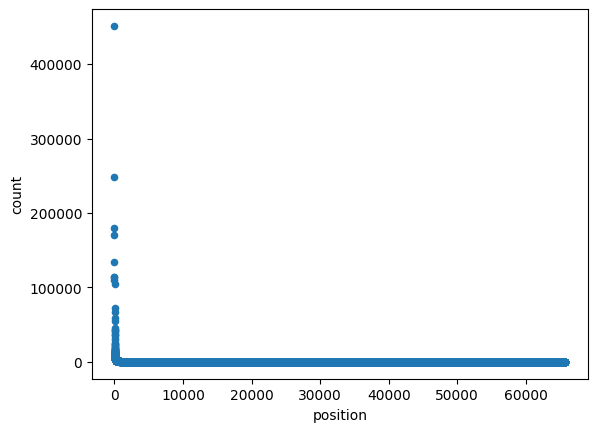

In [37]:
df              = pd.DataFrame(frequency, columns=["token", "count"])
df["position"] = df.apply((lambda x : x.name), axis=1)
df.plot.scatter(x="position", y="count")

We graph the relationship between the position in the rank and the "zipf" value for each row in the DataFrame, observing how some words are much more common than others in natural language, meaning that an small number of words are used all the time, while others are used rarely. In this case we use it to showcase the corpus without some normalization to remove this words that hoard the corpus analysis, so we are able to see this behaviour.

<Axes: xlabel='position', ylabel='zipf'>

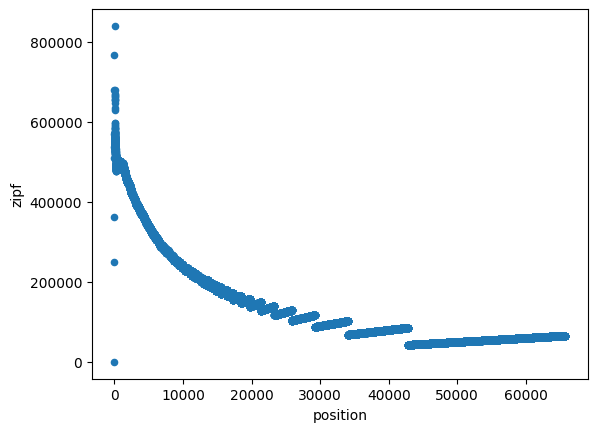

In [38]:
df["zipf"]= df.apply((lambda x: x.name*x["count"]), axis=1)
df.plot.scatter(x='position',y='zipf')

We observe the number of tokens after removing the stopwords.

In [39]:
new_frequency = remove_stopwords(frequency)
new_frequency[:20]

Function 'remove_stopwords' executed in 0.0269s


[(',', 451268),
 ('.', 180527),
 (':', 44898),
 ('¿', 23434),
 ('?', 19212),
 ('LÓPEZ', 15320),
 ('MANUEL', 15151),
 ('ANDRÉS', 15113),
 ('OBRADOR', 15088),
 ('PRESIDENTE', 15088),
 ('presidente', 13860),
 ('mil', 13601),
 (';', 13074),
 ('México', 12359),
 ('si', 12087),
 ('va', 11947),
 ('vamos', 10370),
 ('Entonces', 10262),
 ('‘', 10073),
 ('aquí', 8251)]

We perform the elimination of characters and numbers within our corpus tokens and see which words make sense in our corpus.

In [40]:
new_frequency = clean_alphanumeric(new_frequency)
new_frequency[:20]

Function 'clean_alphanumeric' executed in 0.0194s


[('LÓPEZ', 15320),
 ('MANUEL', 15151),
 ('ANDRÉS', 15113),
 ('OBRADOR', 15088),
 ('PRESIDENTE', 15088),
 ('presidente', 13860),
 ('mil', 13601),
 ('México', 12359),
 ('si', 12087),
 ('va', 11947),
 ('vamos', 10370),
 ('Entonces', 10262),
 ('aquí', 8251),
 ('ver', 7708),
 ('pues', 7422),
 ('dos', 7242),
 ('gobierno', 7115),
 ('pueblo', 6874),
 ('millones', 6782),
 ('ahí', 6682)]

After the above steps, we can create our criteria and eliminate certain tokens that do not contribute to our analysis.

In [41]:
tokens_to_remove  = ["LÓPEZ", "MANUEL", "ANDRÉS", "OBRADOR", "PRESIDENTE", "PREGUNTA"]
new_frequency     = clean_unnecessary_tokens(new_frequency, tokens_to_remove)

Function 'clean_unnecessary_tokens' executed in 0.0147s


We make all tokens lowercase.

In [42]:
new_frequency     = lowercase_tokens(new_frequency)

Function 'lowercase_tokens' executed in 0.0204s


We create the graph again to see the results after applying the filtering to the corpus. In here we will see a more curved corner on the left, which means that we have the stop words that had a lot of weight and produced a more pronounced curve.

<Axes: xlabel='position', ylabel='count'>

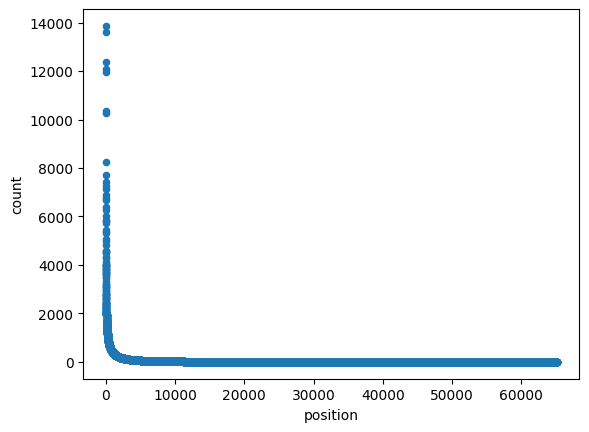

In [43]:
df = pd.DataFrame(new_frequency, columns =['token', 'count'])
df["position"]= df.apply((lambda x: x.name), axis=1)
df.plot.scatter(x='position',y='count')

Now here we can this that words are mor disperced or normalized, so stop words dont have a very heavy weight.

<Axes: xlabel='position', ylabel='zipf'>

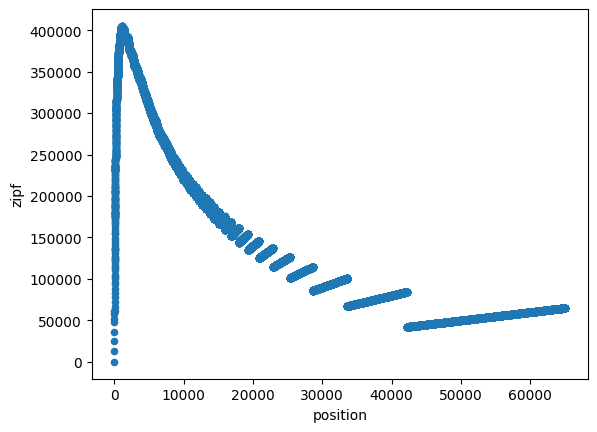

In [44]:
df["zipf"]= df.apply((lambda x: x.name*x["count"]), axis=1)
df.plot.scatter(x='position',y='zipf')

In [45]:
df.head(20)

,token,count,position,zipf
0,presidente,13860,0,0
1,mil,13601,1,13601
2,méxico,12359,2,24718
3,si,12087,3,36261
4,va,11947,4,47788
5,vamos,10370,5,51850
6,entonces,10262,6,61572
7,aquí,8251,7,57757
8,ver,7708,8,61664
9,pues,7422,9,66798


We create a word cloud graph a set of most frequent words. We will be able to see that "publico", "mexicanos", "palacio", "servicio", "medico", "obra" and "empresa", which can help us to identify general themes of the president, like in this case, we could see themes like ifraesctructure and medical service.

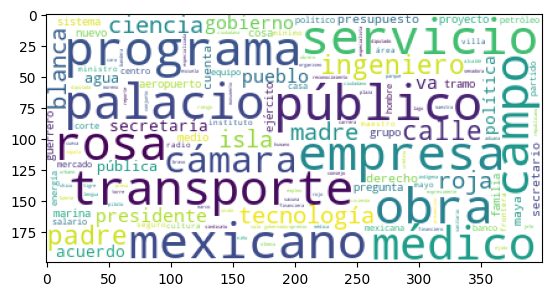

In [46]:
words_from_dataframe = ' '.join(df.values.flatten().astype(str))
oc_cloud= WordCloud(background_color='white', max_words=300,
                    max_font_size=40,random_state=1).generate(words_from_dataframe)
plt.imshow(oc_cloud)

We use nltk to analyze our filtered corpus and extract concordance lines for specific words, giving us context before and after the word. This helps us see the context in which a word could appear in general.

In [47]:
analyzer = nltk.Text(corpus.words())
analyzer.concordance("México")

Displaying 25 of 12415 matches:
a mentir para atacar al Gobierno de México . el expresidente Felipe Calderón H
renaje sobre la playa no ocurrió en México , sino en una playa de España . Así
mente , para golpear al Gobierno de México y que les sirvió al expresidente Ca
adio , vean la televisión . Es otro México , no es el que se está viviendo aho
 que ellos se sentían los dueños de México , entonces les molesta mucho que ah
agonista principal sea el pueblo de México , porque no tienen convicciones dem
ndo . Y no es un asunto nada más de México , es del mundo . ¿ Ustedes creen qu
tre todos de que no haya tortura en México , es decir , en México no hay tortu
a tortura en México , es decir , en México no hay tortura , eso es algo histór
 muy fuerte el que el presidente de México señale a estos jueces aquí . Entonc
ver . Se le detiene en la Ciudad de México , que es el 18 de agosto . Lo liber
do el país . No hay un municipio de México , uno de México , que no tenga un p
hay un municipio de 

In [48]:
analyzer.concordance("López")

Displaying 25 of 16675 matches:
ón Mexicana PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Buenos días . Ánimo . Ya n
obierno del presidente Andrés Manuel López Obrador , aunque para ello tenga que
oritaria del gobierno del presidente López Obrador . El periodista Raymundo Riv
nado por el presidente Andrés Manuel López Obrador . La crítica no es tolerable
ir en contra de la administración de López Obrador . Todo lo manejan al respect
tración del presidente Andrés Manuel López Obrador , lo cual es falso . Esta de
u permiso . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Vamos a la fila 3 , fila 3
atenderme . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Muy bien . Pues vamos a qu
 de Jesús . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Tenemos información de que
 tardaría . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : De acuerdo . INTERLOCUTOR 
residente . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Quedamos en la fila 3 , ¿ 
 política . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Pues mire , lo que sucede 
: ¿ Dond

We also used nltk's collocations, which provides us with pairs of words that frequently appear together in the corpus.

In [49]:
analyzer.collocations()

ANDRÉS MANUEL; PRESIDENTE ANDRÉS; LÓPEZ OBRADOR; MANUEL LÓPEZ; Estados
Unidos; por ciento; señor presidente; Tren Maya; todos los; nada más;
Guardia Nacional; RAMÍREZ CUEVAS; JESÚS RAMÍREZ; García Luna; Buenos
días; Poder Judicial; Quintana Roo; Muchas gracias; Baja California;
sobre todo


## Embeddings

Embeddings are vector representations of words, phrases, or even entire documents in a continuous, high-dimensional space. These vectors are designed to capture the semantic and contextual relationships between words or text elements. Each dimension of the vector corresponds to a specific feature or property of the word or text, and the values in those dimensions encode information about the word's meaning, usage, or context. Embeddings are generated through techniques like Word2Vec, GloVe, and more recently, from models like BERT, LLaMa and GPT-3.

In [50]:
df

,token,count,position,zipf
0,presidente,13860,0,0
1,mil,13601,1,13601
2,méxico,12359,2,24718
3,si,12087,3,36261
4,va,11947,4,47788
...,...,...,...,...
65077,externando,1,65077,65077
65078,investigarlos,1,65078,65078
65079,externaremos,1,65079,65079
65080,manifestarlas,1,65080,65080


In [51]:
!pip install torchtext

### GloVe Embeddings
Stands for Global Vectors for Word Representation, is an unsupervised machine learning technique for the generation of word embeddings, which are dense vector representations of words in a high-dimensional space. GloVe was developed by researchers at Stanford University, and its key innovation lies in combining both global and local information during the training process. It utilizes a large corpus of text data to build an co-occurrence matrix that represents how often words appear together in context windows. It is actually considered an unsupervised learning algorithm. It is important to remark that the co-ocurrence matrix is a fundamental concept for GloVe. Co-ocurrence refers to the idea that words used in similar contexts are more likely to be related by their meaning. So the co-ocurrence matrix where each row and column refers to a word in the vocabulary, and the elements measure how often words appear with each other within a window.


In [52]:
import torch
import torchtext.vocab as vocab

For this implementation, we have downloaded the 6 Billion parameters embeddings and we are using some built in functions of pytorch that automates the download and obtention of the embeddings. This pretrained vector model was trained with a 2014 wikipedia corpus and Gigaword. It's worth mentioning that GloVe was trained with an “english” corpus, therefore, the GloVe won’t be able to embed our complete corpus.

In [53]:
glove = vocab.GloVe(name='6B', dim=100)

In [54]:
print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


In this case, we iterate over the corpus and then get the embeddings for our corpus. We then use TSNE to reduce the dimensions  of the embeddings and plot them on a 2D representation.

In [55]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [56]:
get_word("idolo")

tensor([-0.2384, -0.4166,  0.2639,  0.7823, -0.4305, -0.0784,  0.5448,  0.2084,
         0.1916, -0.7260,  0.1376, -0.0535, -0.1257,  0.2975, -0.3390,  0.1882,
        -0.3035,  0.4057,  0.0938,  0.4012,  0.1799, -0.1351, -0.4766, -0.0226,
        -0.0407,  0.6021, -0.1469,  0.1161,  0.3504, -0.0220,  0.0079, -0.7572,
        -0.3142,  0.0492, -0.2299, -0.0455, -0.4619, -0.5788,  0.1020,  0.3163,
         0.5873,  0.1444,  0.0363,  0.0109, -0.2745, -0.7890, -0.1742,  0.7213,
        -0.3956,  0.1505,  0.1213,  0.1618, -0.6333, -0.3902,  0.3238,  0.4498,
        -0.1396,  0.3086, -0.4190, -0.2498, -0.3205, -0.7572, -0.3245, -0.8803,
         0.3841,  0.1420, -0.8674, -0.0712,  0.3599,  0.1558,  0.6275,  0.4883,
         0.1845,  0.3039, -0.2994,  0.3944,  0.2047,  0.5530,  0.5894,  0.0218,
        -0.2437, -0.2351,  0.0752, -0.0642,  0.3435,  0.1865, -0.3076,  0.1613,
         0.2608,  0.3506, -0.0951,  0.0971,  0.3906, -0.0252,  0.5598, -0.0302,
         0.1836,  0.0717, -0.3901,  0.01

In [57]:
df["token"].to_numpy()

array(['presidente', 'mil', 'méxico', ..., 'externaremos',
       'manifestarlas', 'llamaos'], dtype=object)

In [58]:
df = pd.DataFrame(new_frequency, columns =['token', 'count'])

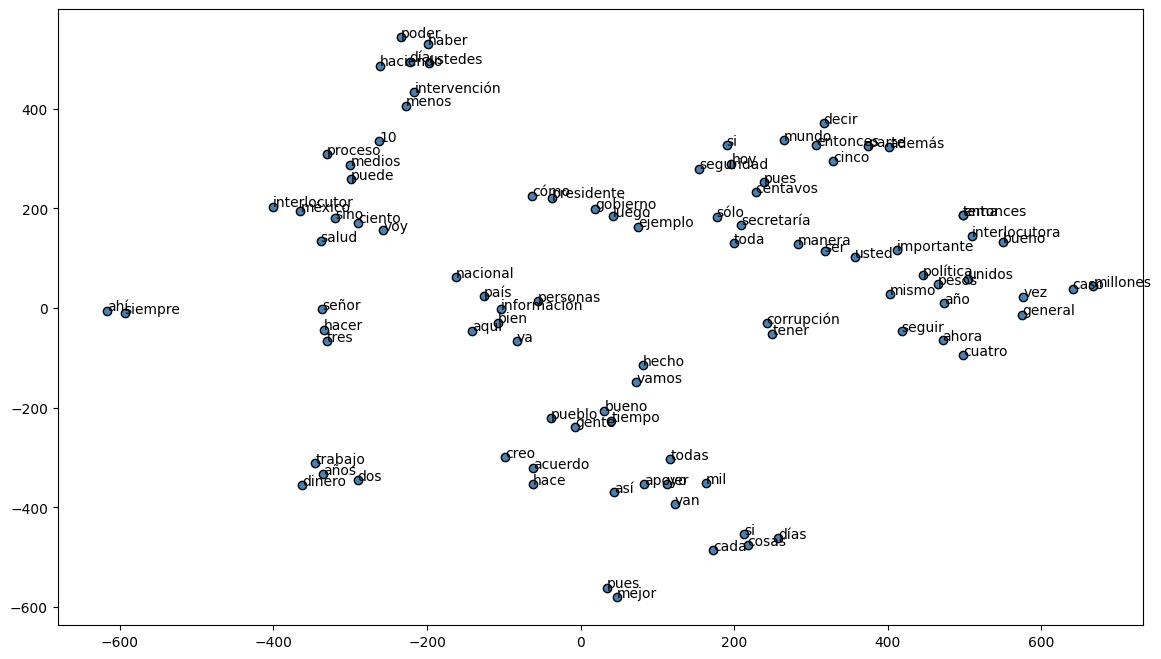

In [59]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words_to_plot = df["token"].to_numpy()

# Get the GloVe vectors for the words
# word_vectors = [glove.vectors[glove.stoi[word]] for word in words_to_plot]
word_vectors  = []
for word in words_to_plot[:100]:
  try:
    word_vectors.append(glove.vectors[glove.stoi[word]])
  except:
    continue


word_vectors = torch.stack(word_vectors)  # Convert to a PyTorch tensor
word_labels = words_to_plot

# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)

# Create the scatter plot
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(word_labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

plt.show()

After plotting the result, we are not able to see an accurate representation or a cluster of similar vector space words. As we said, this might be happening because this model was trained in an English corpus. Because of this, we decided to implement another method to try to find a better representation of the corpus.


### SkipGrams PyTorch
Since skip-grams predict multiple context words from a single target word, this increases the number of training examples for each target word in the dataset. As a result, skip-gram models tend to excel in capturing rare words and phrases, often yielding more accurate embeddings in specific scenarios. Given the size of our corpus, we anticipated that this implementation would enable us to extract more comprehensive information for the embeddings. It's worth noting that at this stage, we made the decision to migrate the project to another cloud environment equipped with greater RAM memory and computational power. While a Bag of Words approach might have been faster, we had confidence that using skip-grams would prove to be more advantageous for our specific needs.

Skip-grams are a technique for generating word embeddings. Unlike other techniques like Continuous Bag of Words, skip-grams are designed to predict the context word, wich are words around the word that gives context. Which means that skip-grams are effective at capturing the semantic and syntactic relationships.



In [60]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

CONTEXT_SIZE  = 2

We decided to implement the model architecture in pytorch.  First, we download the Spanish stopwords list from NLTK and then apply a series of data cleaning and filtering steps to the text. This includes removing common stopwords, eliminating numeric tokens, removing non-alphanumeric characters, converting words to lowercase, and filtering out empty elements, resulting in a cleaned and preprocessed list of words for further analysis or natural language processing tasks.

In [61]:
nltk.download('stopwords')
stop_words  = set(stopwords.words('spanish'))
our_words   = corpus.words()
filtered_text = [word for word in our_words if word.lower() not in stop_words]
filtered_text = [word for word in filtered_text if not re.match(r'^\d+$', word)]
filtered_text = [re.sub(r'[^\w\s]', '', word) for word in filtered_text]
filtered_text = [word.lower() for word in filtered_text]
filtered_text = list(filter(None, filtered_text))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this code, the variable “text” is set to the “filtered_text”' which is the preprocessed and cleaned text. Then, “split_ind” is calculated as 80% of the length of “text”' which is used as a split point for dividing the text into training and testing data. The “vocab” variable is created to store the set of unique words in the '”text”' and “vocab_size” represents the size of this vocabulary. Finally, two dictionaries, “w2i” (word to index) and “i2w” (index to word), are created to establish a mapping between words and their corresponding numerical indices.

In [62]:
text          = filtered_text

split_ind = (int)(len(text) * 0.8)

vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 56245


The create_skipgram_dataset function generates a dataset for training a skip-gram word embedding model. It pairs central words with context words within a fixed window and assigns a label of “1” to valid context words and “0” to randomly selected words outside the window. This dataset is used to train the skip-gram model, which learns word embeddings capturing word co-occurrence patterns in the text. Each data tuple consists of a central word, a context word (positive or negative), and a corresponding label.

In [63]:
import random
def create_skipgram_dataset(text):
  data = []
  for i in range(2, len(text) - 2):
    data.append((text[i], text[i-2], 1))
    data.append((text[i], text[i-1], 1))
    data.append((text[i], text[i+1], 1))
    data.append((text[i], text[i+2], 1))

    for _ in range(4):
      if random.random() < 0.5 or i >= len(text)-3:
        rand_id   = random.randint(0, i-1)
      else:
        rand_id   = random.randint(i+3, len(text)-1)
      data.append((text[i], text[rand_id], 0))
    return data

In [64]:
skipgram_train  = create_skipgram_dataset(text)
print("skipgram sample", skipgram_train[0])

skipgram sample ('flores', 'año', 1)


In [65]:
skipgram_train

[('flores', 'año', 1),
 ('flores', 'ricardo', 1),
 ('flores', 'magón', 1),
 ('flores', 'precursor', 1),
 ('flores', 'corrupción', 0),
 ('flores', 'así', 0),
 ('flores', 'obras', 0),
 ('flores', 'resaltar', 0)]

This is a SkipGram class is a PyTorch neural network module designed for training a skip-gram word embedding model. It takes as input the vocabulary size and the desired embedding size. The class initializes an embedding layer based on these parameters. In the forward method, it computes the dot product of embeddings for a central word (wich is the focus) and a context word (as the context), applies a logistic sigmoid function to the result, and returns the probabilities of the context word being a valid context for the word.


In [66]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, embed_size):
    super(SkipGram, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embed_size)
  def forward(self, focus, context):
    embed_focus     = self.embeddings(focus).view((1, -1))
    embed_ctx       = self.embeddings(context).view((1, -1))
    score           = torch.mm(embed_focus, torch.t(embed_ctx))
    log_probs       = F.logsigmoid(score)
    return log_probs

The train_skipgram function is responsible for training a skip-gram word embedding model. It sets up the training parameters such as the embedding size, learning rate, and number of epochs, as well as initializes a list to track the training losses. The function uses mean squared error loss as the loss function and creates an instance of the SkipGram model. It then employs stochastic gradient descent optimization to update the model's parameters during training. The loop iterates through the specified number of epochs, processing training data in the form of word pairs and their labels. For each pair, it computes the loss, performs backpropagation, and updates the model's parameters.


In [67]:
def train_skipgram():
  embed_size        = 100
  learning_rate     = 0.001
  n_epoch           = 30

  losses            =  []
  loss_fn           = nn.MSELoss()
  model             = SkipGram(vocab_size, embed_size)
  print(model)
  optimizer         = optim.SGD(model.parameters(), lr=learning_rate)

  for epoch in range(n_epoch):
    total_loss      = .0
    for in_w, out_w, target in skipgram_train:
      in_w_var      = Variable(torch.LongTensor([w2i[in_w]]))
      out_w_var     = Variable(torch.LongTensor([w2i[out_w]]))

      model.zero_grad()
      log_probs     = model(in_w_var, out_w_var)
      loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))

      loss.backward()
      optimizer.step()

      total_loss    += loss.data.item()
    losses.append(total_loss)
  return model, losses

In [68]:
skipgram_model, skipgram_losses = train_skipgram()

SkipGram(
  (embeddings): Embedding(56245, 100)
)


The test_skipgram function is designed for evaluating the performance of a trained skip-gram word embedding model.The printed accuracy score represents the model's ability to predict context words based on central words in the skip-gram. The model is not that accurate, since it has an accuracy of 0.5, wich could be optimized by augmenting the skipgram interval size. But this would require more computing and more memory.

In [69]:
def test_skipgram(test_data, model):
  correct_ct      = 0
  for in_w, out_w, target in test_data:
    in_w_var      = Variable(torch.LongTensor([w2i[in_w]]))
    out_w_var     = Variable(torch.LongTensor([w2i[out_w]]))
    # print(f"target: {target}")
    # print(f"in w var: {in_w_var}")
    # print(f"out w var: {out_w_var}")

    model.zero_grad()
    log_probs     = model(in_w_var, out_w_var)
    # print(f"log_probs: {log_probs}")
    _, predicted  = torch.max(log_probs.data, 1)
    # print(f"1. line: {_}")
    # print(f"1. predicted: {predicted}")
    predicted = predicted[0]
    # print(f"2. predicted: {predicted}")
    if predicted == target:
      correct_ct += 1
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [70]:
skipgram_model.embeddings(torch.tensor([30]))

tensor([[-0.7548,  0.4303,  0.8474, -0.4207, -1.5176, -0.6869, -0.6911,  0.9373,
          2.1845, -0.6675,  0.5340,  0.0702,  0.3724, -0.4382, -1.1334, -0.0592,
         -2.1585,  0.9951,  1.6538,  1.1070,  0.4400,  1.2433,  0.4911,  0.6961,
         -0.2398, -1.7226, -0.9291, -1.2290, -0.2063, -0.2325,  1.1035, -1.0980,
          1.9730, -1.3280, -0.6584, -0.9669, -0.8926,  0.0541, -0.3959,  0.6172,
          0.1799, -0.0242, -0.0532,  0.1972,  1.1226,  0.4113, -1.5253, -1.2302,
         -1.0240,  0.1233, -0.3503, -1.0396, -0.0044, -0.7909, -0.8263, -1.0120,
          1.8898,  0.2831,  0.5599, -1.3810, -0.3644,  0.1331, -0.6485, -1.1922,
         -0.0499, -0.1301, -0.5577, -0.6959, -0.4628,  0.3639,  0.4251, -1.1798,
         -0.9401,  0.1733,  0.6126,  1.6237, -1.3902, -0.6368, -1.5602, -2.4015,
          1.8897,  0.0495,  1.3412,  0.6560,  1.4327, -0.6373, -1.2352, -1.0565,
         -1.2138,  0.0876, -0.7317, -0.1369,  0.8804, -0.4548,  0.8764, -0.4297,
         -0.2051,  0.0218,  

In [71]:
test_skipgram(skipgram_train, skipgram_model)

Accuracy: 0.0% (0/8)
Accuracy: 0.0% (0/8)
Accuracy: 0.0% (0/8)
Accuracy: 0.0% (0/8)
Accuracy: 12.5% (1/8)
Accuracy: 25.0% (2/8)
Accuracy: 37.5% (3/8)
Accuracy: 50.0% (4/8)


In [72]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [73]:
# Extract word embeddings from the model
# tardó casi 12 minutos
word_embeddings = skipgram_model.embeddings.weight.data.numpy()

# Perform t-SNE on the word embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(word_embeddings)

In [74]:
print("one")

one


Then we use the t-NSE algorithm, to reduce the embeddings algorithm and plot them on 2d.


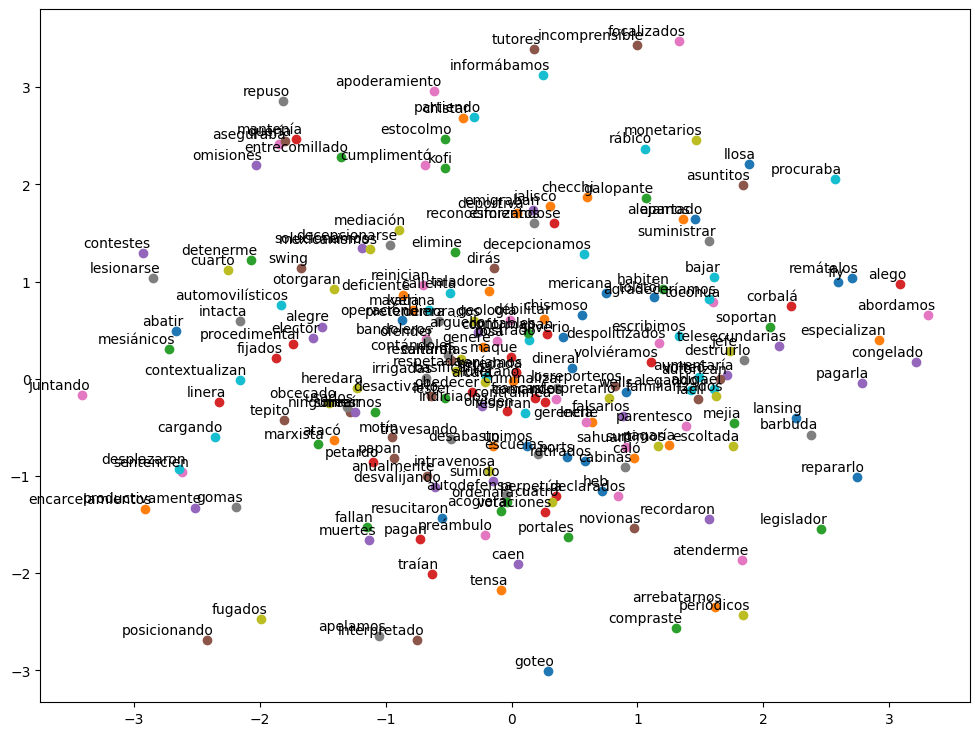

In [75]:

# Visualize the embeddings
plt.figure(figsize=(12, 9))
counter = 0
for i, label in i2w.items():
    if counter == 200:
      break
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    counter += 1

plt.show()

In the scatter plot we are not able to see any clusters or patterns, this must be caused because this is not a very complex corpus and very reduced compared to corpuses like GloVe, and there are many things we could improve in the SkipGram model, like augmenting the amount of words in the skipgrams to augment the amount of context. But it was very interesting to be able to develop our custom skip gram model.

### Word2Vec - Spanish Billion Word Corpus and Embeddings
https://crscardellino.ar/SBWCE/

In [76]:
! wget -P ./corpus_work/ https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz

--2023-11-04 08:38:17--  https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1123304474 (1.0G) [application/x-gzip]
Saving to: ‘./corpus_work/SBW-vectors-300-min5.bin.gz.4’

100%[====================================>] 1,123,304,474 15.6MB/s   in 70s    

2023-11-04 08:39:28 (15.3 MB/s) - ‘./corpus_work/SBW-vectors-300-min5.bin.gz.4’ saved [1123304474/1123304474]



In [77]:
# !gzip -d ./corpus_work/SBW-vectors-300-min5.bin.gz

In [78]:
# https://crscardellino.ar/SBWCE/
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [79]:
wv_from_bin = KeyedVectors.load_word2vec_format("./corpus_work/SBW-vectors-300-min5.bin", binary=True)

In [80]:
similar_words = wv_from_bin.most_similar(text[10], topn=10)
print(f"For word: {text[10]}")
print(similar_words)

For word: lópez
[('Liciaga', 0.7222180962562561), ('guillen', 0.7196347117424011), ('nuñez', 0.7183104753494263), ('Calesero', 0.7153816819190979), ('Tepo', 0.7130030989646912), ('Hernandéz', 0.7125709652900696), ('Ocanto', 0.7114126086235046), ('Huaroco', 0.7110150456428528), ('Gálvis', 0.7109631896018982), ('corado', 0.70835942029953)]


In [81]:
embeddings = np.array([wv_from_bin[word] for word in list(text) if word in wv_from_bin])
text = np.array([word for word in list(text) if word in wv_from_bin])

In [82]:
embeddings.shape

(2128683, 300)

In [83]:
embeddings_to_plot = embeddings[:200]

In [84]:
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_to_plot)

In [85]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans = kmeans.fit(embeddings[:2000])
clusters = kmeans.predict(embeddings_to_plot)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


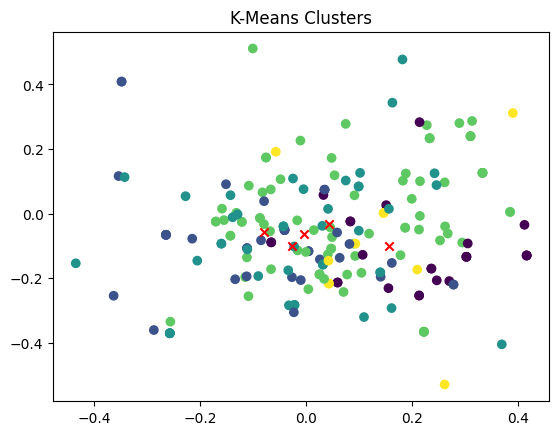

In [86]:
plt.scatter(embeddings_to_plot[:, 0], embeddings_to_plot[:, 1], c=clusters, cmap='viridis')
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x')
plt.title("K-Means Clusters")
plt.show()

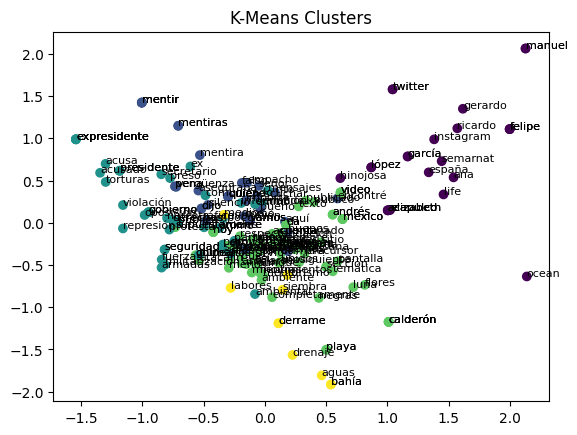

In [87]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (x, y), fontsize=8)
plt.title("K-Means Clusters")
plt.show()

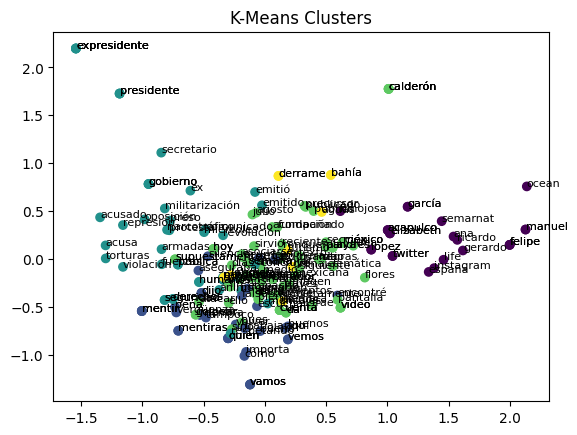

In [114]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 2], c=clusters, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (x, z), fontsize=8)
plt.title("K-Means Clusters")
plt.show()

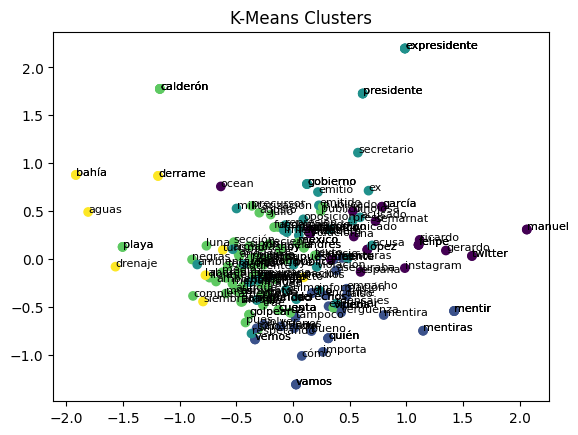

In [115]:
plt.scatter(reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=clusters, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (y, z), fontsize=8)
plt.title("K-Means Clusters")
plt.show()

In [90]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=15)
cluster_labels = dbscan.fit_predict(embeddings_to_plot)

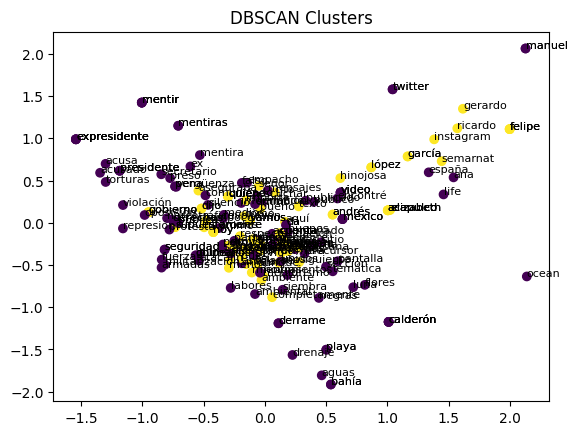

In [91]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (x, y), fontsize=8)
plt.title("DBSCAN Clusters")
plt.show()

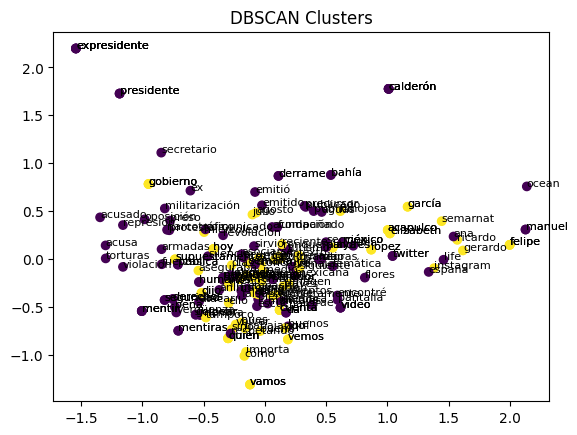

In [112]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 2], c=cluster_labels, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (x, z), fontsize=8)
plt.title("DBSCAN Clusters")
plt.show()

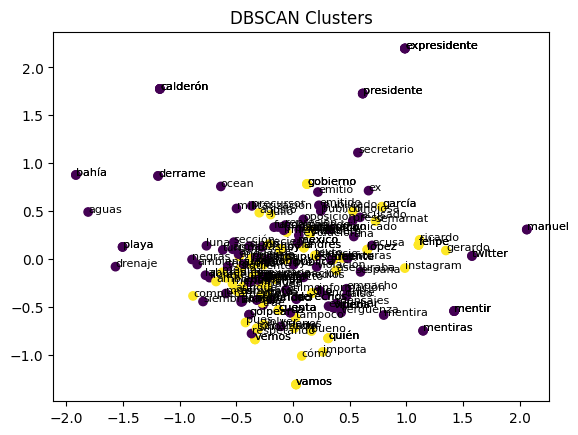

In [113]:
plt.scatter(reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=cluster_labels, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (y, z), fontsize=8)
plt.title("DBSCAN Clusters")
plt.show()

### Zero Shot Model
https://huggingface.co/Recognai/bert-base-spanish-wwm-cased-xnli

In [94]:
!pip install umap-learn

In [95]:
from transformers import pipeline

In [96]:
classifier = pipeline("zero-shot-classification",
                       model="Recognai/bert-base-spanish-wwm-cased-xnli")

In [97]:
classifier(
    "Maradona ganó el partido",
    candidate_labels=["cultura", "sociedad", "economia", "salud", "seguridad", "educación", "infraestructura"],
    hypothesis_template="Este ejemplo es {}."
)

{'sequence': 'Maradona ganó el partido',
 'labels': ['cultura',
  'seguridad',
  'infraestructura',
  'salud',
  'economia',
  'sociedad',
  'educación'],
 'scores': [0.25365114212036133,
  0.20735694468021393,
  0.17590732872486115,
  0.11877739429473877,
  0.09899412840604782,
  0.07355872541666031,
  0.0717543289065361]}

In [98]:
directory_path  = "output_mañaneras/"
new_corpus      = PlaintextCorpusReader(directory_path, '.*\.txt')

In [111]:
from tqdm import tqdm
import multiprocessing

In [100]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing
results = []

# 10 files, almos 30 minutes

def process_file(file_id):
    text = new_corpus.raw(file_id)
    paragraphs = text.split('\n')
    paragraph_results = []

    for paragraph in paragraphs:
        if not paragraph == "":
            result = classifier(
                paragraph,
                candidate_labels=["cultura", "sociedad", "economia", "salud", "seguridad", "educación", "infraestructura"],
                hypothesis_template="Este ejemplo es {}."
            )
            paragraph_results.append(result["labels"][0])

    return paragraph_results
num_processes = multiprocessing.cpu_count()
file_ids = new_corpus.fileids()[:10]

with tqdm(total=len(file_ids), desc="Processing Files") as pbar:
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        for paragraph_results in executor.map(process_file, file_ids):
            results.extend(paragraph_results)
            pbar.update(1)

Processing Files: 100%|██████████| 10/10 [35:24<00:00, 212.47s/it] 


In [101]:
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('spanish'))
filtered_text = []

for fileid in new_corpus.fileids()[:10]:
    words = word_tokenize(corpus.raw(fileid))
    words = [word for word in words if word.lower() not in stop_words]
    filtered_text.extend(words)
set_filtered_text = list(set(filtered_text))
set_filtered_text = [string.lower() for string in set_filtered_text]

In [102]:
embeddings_zero_shot = np.array([wv_from_bin[word] for word in set_filtered_text if word in wv_from_bin])

In [103]:
text_embs = np.array([word for word in set_filtered_text if word in wv_from_bin])

In [104]:
# Perform t-SNE on the word embeddings
tsne_zs = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d_zs = tsne.fit_transform(embeddings_zero_shot)

In [105]:
i2w_zs = {i: w for i, w in enumerate(text_embs)}

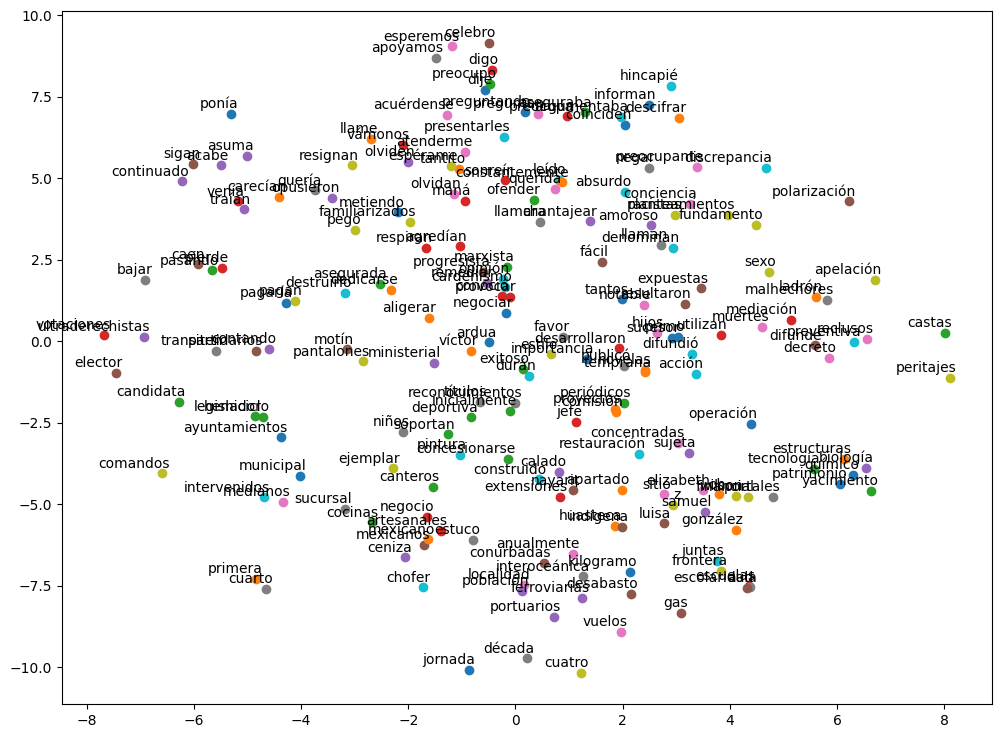

In [106]:
# Visualize the embeddings
plt.figure(figsize=(12, 9))
counter = 0
for i, label in i2w_zs.items():
    if counter == 200:
      break
    if label == "salistes":
        continue
    x, y = embeddings_2d_zs[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    counter += 1

plt.show()

In [107]:
from umap import UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(embeddings_2d_zs)


/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


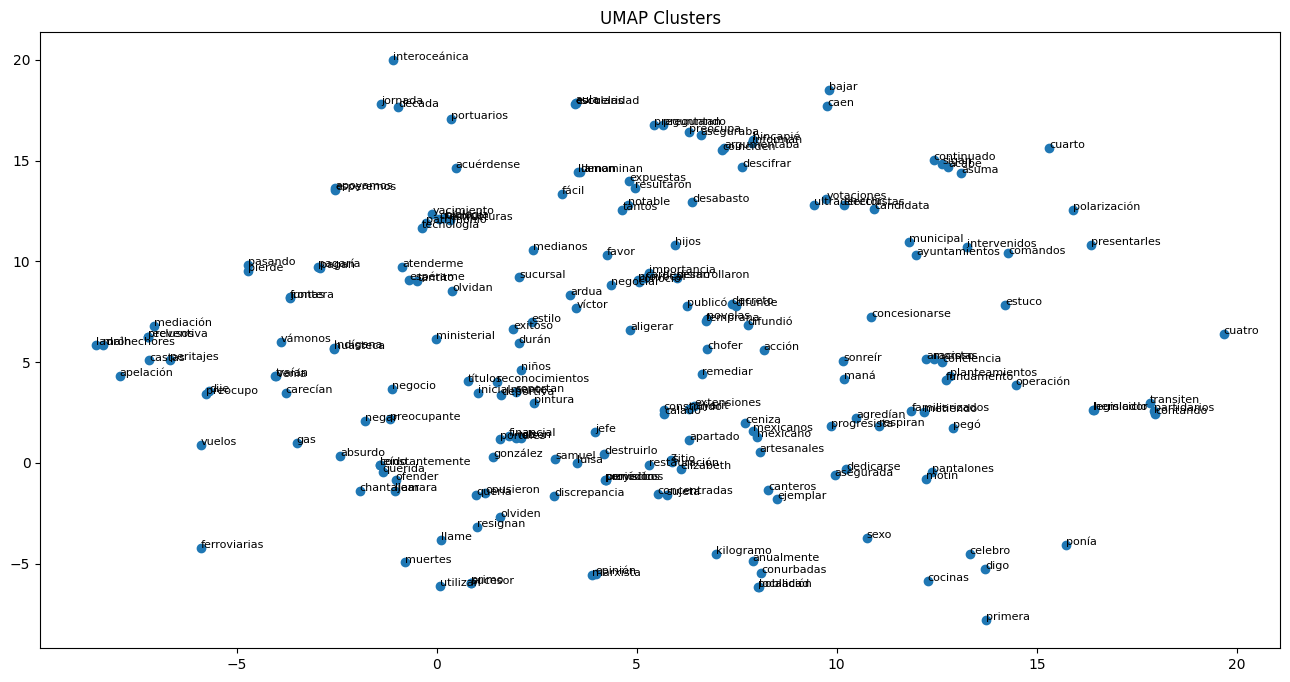

In [108]:
plt.figure(figsize=(16,8))
plt.scatter(proj_2d[:, 0][:200], proj_2d[:, 1][:200])
counter = 0
for i, (x, y) in enumerate(proj_2d):
    if counter == 200:
        break
    plt.annotate(text_embs[i], (x, y), fontsize=8)
    counter += 1
plt.title("UMAP Clusters")
plt.show()

In [109]:
from collections import Counter

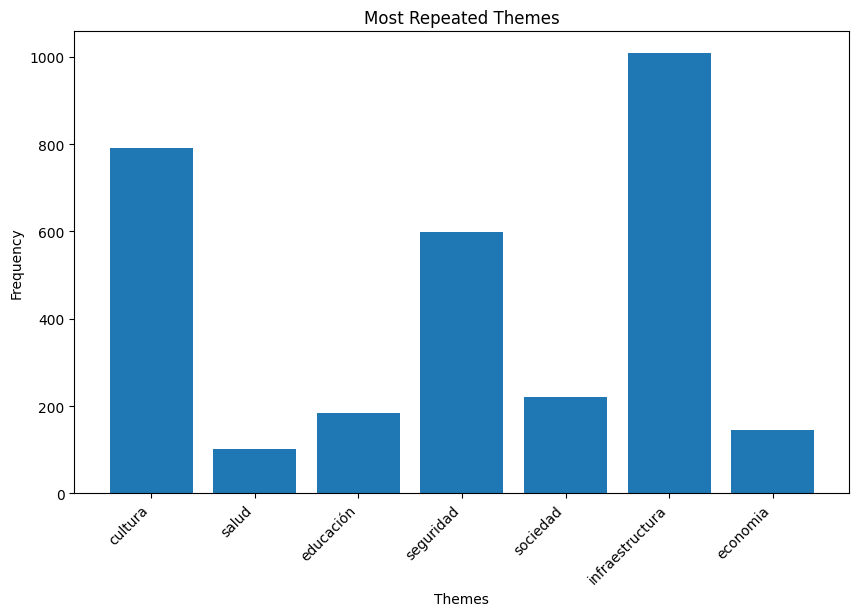

In [110]:
theme_counts = Counter(results)
themes, counts = zip(*theme_counts.items())

plt.figure(figsize=(10, 6))
plt.bar(themes, counts)
plt.xlabel('Themes')
plt.ylabel('Frequency')
plt.title('Most Repeated Themes')
plt.xticks(rotation=45, ha='right')
plt.show()

## References

Chakraborty, D. (2020) An introduction to the global vectors (glove) algorithm, W&amp;B. Available at: https://wandb.ai/authors/embeddings-2/reports/An-Introduction-to-the-Global-Vectors-GloVe-Algorithm--VmlldzozNDg2NTQ (Accessed: 04 November 2023).


Chawla, J.S. (2020) Word vectorization using glove, Medium. Available at: https://medium.com/analytics-vidhya/word-vectorization-using-glove-76919685ee0b (Accessed: 04 November 2023).